In [43]:
import pandas as pd
import glob
import os

# Define the folder path
folder_path = "raw_data"  # Change this to your actual folder path

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read each CSV file and store them in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
df_combined = pd.concat(df_list, ignore_index=True)

# cleaning
df_combined = df_combined.assign(snp = df_combined.snp.str.replace('`', ''))

# add reference alleles
reference = pd.read_csv('reference_genome.csv')

# add onto main df
df_combined = df_combined.merge(reference, how = 'left')

# drop the n = 0 rows
df_combined = df_combined[df_combined.n_total > 0]

# Display the combined DataFrame
df_combined.head()

,phenotype,snp,adjustment,beta,OR,SE,p,type,n_total,n_cases,...,OR.fixed,SE.fixed,p.fixed,beta.random,OR.random,SE.random,p.random,description,group,reference_hg38
0,110.00,16:4353432_T,none,-0.000151,0.999849,0.005953,0.979734,logistic,1237800,177241,...,0.999849,0.005953,0.979734,0.006178,1.006197,0.012305,0.615617,Dermatophytosis / Dermatomycosis,infectious diseases,C
1,110.10,16:4353432_T,none,-0.000312,0.999688,0.006069,0.959032,logistic,1237416,170510,...,0.999688,0.006069,0.959032,0.010304,1.010357,0.015522,0.506800,Dermatophytosis,infectious diseases,C
2,110.11,16:4353432_T,none,0.002182,1.002185,0.006721,0.745428,logistic,1251709,128081,...,1.002185,0.006721,0.745428,0.009433,1.009478,0.016507,0.567693,Dermatophytosis of nail,infectious diseases,C
3,110.12,16:4353432_T,none,0.000275,1.000275,0.010969,0.980001,logistic,1251344,36804,...,1.000275,0.010969,0.980001,0.018498,1.018670,0.022352,0.407917,Althete's foot,infectious diseases,C
4,110.13,16:4353432_T,none,0.027595,1.027980,0.016599,0.096426,logistic,1258137,13211,...,1.027980,0.016599,0.096426,0.027595,1.027980,0.016599,0.096426,Dermatophytosis of the body,infectious diseases,C


In [44]:
# extract the SNP data
df_combined[['chrom', 'pos', 'alternate']] = df_combined.snp.str.extract(r'(\d+):(\d+)_([A-Za-z])')

# rename necessary cols
df_combined = df_combined.assign(

    # clean
    phenocode = df_combined.phenotype,
    phenostring = df_combined.description,
    clean_phenotype = df_combined.description.str.lower().str.replace('[ -]', '_', regex = True).str.replace("[',\\]\\[\\(\\)/;&\\.]", "", regex = True),

    # rename
    reference = df_combined.reference_hg38,
    num_samples = df_combined.n_total,
    num_controls = df_combined.n_controls,
    num_cases = df_combined.n_cases,
    se = df_combined.SE,

    maf = round(df_combined.assign(allele_freq2 = 1 - df_combined.allele_freq)[['allele_freq', 'allele_freq2']].min(axis = 1), 2),
    # maf = df_combined.allele_freq,

    # capitalize the first letter
    category = df_combined.group.str.slice(0,1).str.upper() + df_combined.group.str.slice(1),

    # retype
    chrom = df_combined.chrom.astype(int),
    pos = df_combined.pos.astype(int)
)

df_combined['or'] = df_combined.OR
df_combined['af'] = 1 - df_combined.maf

In [47]:
final_cols = [
    'chrom', 'pos', 'reference', 'alternate', 'p',
    'maf', 'af', 'beta', 'se', 'or',  'num_samples', 'num_controls', 'num_cases'
]

In [48]:
# drop all snps that where reference == alternate
df_combined = df_combined[df_combined.reference != df_combined.alternate] 

In [49]:
# check that we got all chromosomes
df_combined[df_combined.chrom.isna()][['snp'] + final_cols]

,snp,chrom,pos,reference,alternate,p,maf,af,beta,se,or,num_samples,num_controls,num_cases


In [50]:
df_combined

,phenotype,snp,adjustment,beta,OR,SE,p,type,n_total,n_cases,...,clean_phenotype,reference,num_samples,num_controls,num_cases,se,maf,category,or,af
0,110.00,16:4353432_T,none,-0.000151,0.999849,0.005953,0.979734,logistic,1237800,177241,...,dermatophytosis__dermatomycosis,C,1237800,1060559,177241,0.005953,0.21,Infectious diseases,0.999849,0.79
1,110.10,16:4353432_T,none,-0.000312,0.999688,0.006069,0.959032,logistic,1237416,170510,...,dermatophytosis,C,1237416,1066906,170510,0.006069,0.21,Infectious diseases,0.999688,0.79
2,110.11,16:4353432_T,none,0.002182,1.002185,0.006721,0.745428,logistic,1251709,128081,...,dermatophytosis_of_nail,C,1251709,1123628,128081,0.006721,0.21,Infectious diseases,1.002185,0.79
3,110.12,16:4353432_T,none,0.000275,1.000275,0.010969,0.980001,logistic,1251344,36804,...,althetes_foot,C,1251344,1214540,36804,0.010969,0.21,Infectious diseases,1.000275,0.79
4,110.13,16:4353432_T,none,0.027595,1.027980,0.016599,0.096426,logistic,1258137,13211,...,dermatophytosis_of_the_body,C,1258137,1244926,13211,0.016599,0.21,Infectious diseases,1.027980,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62427,990.00,7:41266132_A,none,0.002825,1.002829,0.011738,0.809783,logistic,1338623,15799,...,effects_radiation_nos,G,1338623,1322824,15799,0.011738,0.48,Injuries & poisonings,1.002829,0.52
62428,994.00,7:41266132_A,none,0.012255,1.012331,0.007933,0.122374,logistic,1341097,36813,...,sepsis_and_sirs,G,1341097,1304284,36813,0.007933,0.48,Injuries & poisonings,1.012331,0.52
62429,994.10,7:41266132_A,none,0.007507,1.007535,0.027067,0.781516,logistic,1285442,2926,...,systemic_inflammatory_response_syndrome_sirs,G,1285442,1282516,2926,0.027067,0.48,Injuries & poisonings,1.007535,0.52
62430,994.20,7:41266132_A,none,0.012152,1.012226,0.008283,0.142336,logistic,1340915,33612,...,sepsis,G,1340915,1307303,33612,0.008283,0.48,Injuries & poisonings,1.012226,0.52


In [51]:
# sort very important for Pheweb
df_combined = df_combined.sort_values(['phenocode', 'chrom', 'pos'])

In [ ]:
# final file
df_combined[['phenocode', 'phenostring', 'clean_phenotype', 'category'] + final_cols].to_csv('all_data.csv', index = False)

<Axes: >

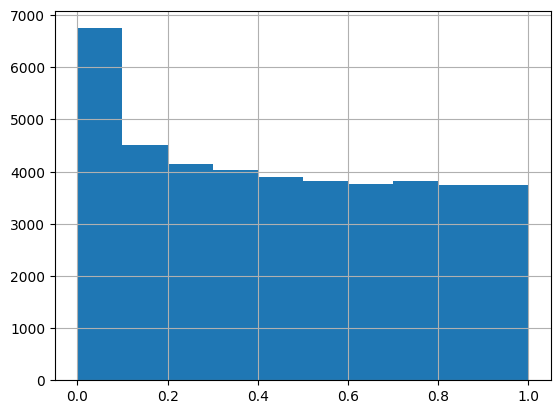

In [55]:
# note that the p-value is raw
df_combined.p.hist()

## Formatting 

I need to format the files a la Github specifications. One file per phenotype

In [56]:
# filtering out phenotypes with n = 0
# this isn't a problem with the phenotypes, this is because we filtered out some genes because the reference alleles didn't match
n_totals = df_combined.groupby('phenocode').n_total.sum()
phenotypes_n_0 = pd.Series(n_totals[n_totals == 0].index)
df_combined = df_combined[~ df_combined.phenocode.isin(phenotypes_n_0)]

In [57]:
unique_phenotypes = df_combined[['phenocode', 'phenostring', 'category', 'clean_phenotype']].drop_duplicates()

# check for consistent phenotype categories
if unique_phenotypes.shape[0] != df_combined.phenocode.nunique():
    raise ValueError("Non-unique phenotype categories. One or more phenotypes have multiple categories")

In [58]:
df_combined.columns

Index(['phenotype', 'snp', 'adjustment', 'beta', 'OR', 'SE', 'p', 'type',
       'n_total', 'n_cases', 'n_controls', 'HWE_p.min', 'allele_freq',
       'n_no_snp', 'k_studies', 'tau2', 'I2.percent', 'Q', 'Q.df', 'Q.p',
       'beta.fixed', 'OR.fixed', 'SE.fixed', 'p.fixed', 'beta.random',
       'OR.random', 'SE.random', 'p.random', 'description', 'group',
       'reference_hg38', 'chrom', 'pos', 'alternate', 'phenocode',
       'phenostring', 'clean_phenotype', 'reference', 'num_samples',
       'num_controls', 'num_cases', 'se', 'maf', 'category', 'or', 'af'],
      dtype='object')

In [59]:
# df_combined[['phenocode', 'phenostring', 'category', 'n_total', 'snp']].drop_duplicates().head(20)

In [ ]:
# remove all files in folder
import os
import glob

files = glob.glob('clean_data/*.csv')
for f in files:
    os.remove(f)

# make a file for each phenotype
for pheno in unique_phenotypes.clean_phenotype:
    df_combined[df_combined.clean_phenotype == pheno][final_cols].to_csv('clean_data/' + str(pheno) + '.csv', index = False)

In [ ]:
pheno_df = unique_phenotypes.assign(
    assoc_files = 'clean_data/' + unique_phenotypes.clean_phenotype + '.csv'
    )[['assoc_files',  'category', 'phenocode', 'phenostring']]

pheno_df.to_csv('pheno-list.csv', index = False)

In [ ]:
pheno_df

,assoc_files,category,phenocode,phenostring
28092,clean_data/dermatophytosis__dermatomycosis.csv,Infectious diseases,dermatophytosis__dermatomycosis,Dermatophytosis / Dermatomycosis
28093,clean_data/dermatophytosis.csv,Infectious diseases,dermatophytosis,Dermatophytosis
28094,clean_data/dermatophytosis_of_nail.csv,Infectious diseases,dermatophytosis_of_nail,Dermatophytosis of nail
28095,clean_data/althetes_foot.csv,Infectious diseases,althetes_foot,Althete's foot
28096,clean_data/dermatophytosis_of_the_body.csv,Infectious diseases,dermatophytosis_of_the_body,Dermatophytosis of the body
...,...,...,...,...
30105,clean_data/effects_radiation_nos.csv,Injuries & poisonings,effects_radiation_nos,Effects radiation NOS
30106,clean_data/sepsis_and_sirs.csv,Injuries & poisonings,sepsis_and_sirs,Sepsis and SIRS
30107,clean_data/systemic_inflammatory_response_synd...,Injuries & poisonings,systemic_inflammatory_response_syndrome_sirs,Systemic inflammatory response syndrome (SIRS)
30108,clean_data/sepsis.csv,Injuries & poisonings,sepsis,Sepsis


In [ ]:
pheno_df.phenocode.value_counts()

phenocode
septic_shock                            1
dermatophytosis__dermatomycosis         1
dermatophytosis                         1
dermatophytosis_of_nail                 1
althetes_foot                           1
                                       ..
helminthiases                           1
arthropod_borne_diseases                1
pediculosis_and_phthirus_infestation    1
infestation_lice_mites                  1
protozoan_infection                     1
Name: count, Length: 1759, dtype: int64

In [ ]:
for i in pheno_df.phenocode:
    print(i)

dermatophytosis__dermatomycosis
dermatophytosis
dermatophytosis_of_nail
althetes_foot
dermatophytosis_of_the_body
dermatomycoses
candidiasis
candidiasis_of_skin_and_nails
mycoses
histoplasmosis
coccidioidomycosis
blastomycotic_infection
aspergillosis
spirochetal_infection
lyme_disease
protozoan_infection
infestation_lice_mites
pediculosis_and_phthirus_infestation
arthropod_borne_diseases
helminthiases
intestinal_helminthiases
other_infectious_and_parasitic_diseases
cancer_of_mouth
cancer_of_lip
cancer_of_tongue
cancer_of_major_salivary_glands
cancer_of_the_gums
cancer_of_the_mouth_floor
cancer_of_larynx_pharynx_nasal_cavities
cancer_of_oropharynx
cancer_of_nasopharynx
cancer_of_hypopharynx
cancer_of_larynx
hx_of_malignant_neoplasm_of_oral_cavity_and_pharynx
cancer_of_of_nasal_cavities
cancer_of_esophagus
cancer_of_stomach
colorectal_cancer
colon_cancer
malignant_neoplasm_of_rectum_rectosigmoid_junction_and_anus
cancer_of_liver_and_intrahepatic_bile_duct
malignant_neoplasm_of_liver_prim

In [40]:
df_combined.maf.isna().sum()

np.int64(0)

<Axes: >

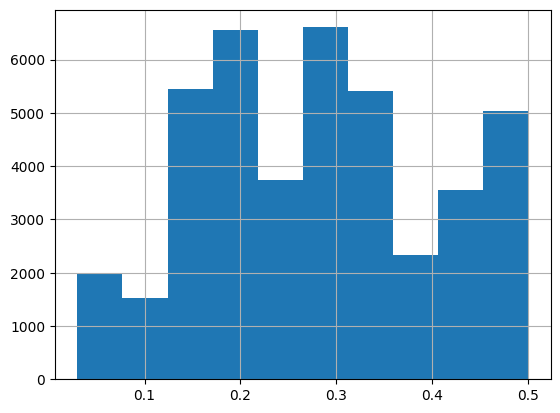

In [41]:
df_combined.maf.hist()

In [42]:
df_combined.maf

28092    0.33
54357    0.15
18186    0.41
26073    0.08
32134    0.23
         ... 
38193    0.04
44250    0.50
8078     0.19
16162    0.27
36174    0.30
Name: maf, Length: 42211, dtype: float64